Episode 0 | Timesteps 1600 | Avg Loss: 0.6301 | Actor Loss: -0.0211 | Critic Loss: 0.6794 | Entropy: 1.4158
Episode 1 | Timesteps 1705 | Avg Loss: 948.8256 | Actor Loss: 0.0028 | Critic Loss: 948.8510 | Entropy: 1.4126
Episode 2 | Timesteps 3305 | Avg Loss: 0.3269 | Actor Loss: -0.0187 | Critic Loss: 0.3738 | Entropy: 1.4098
Episode 3 | Timesteps 3386 | Avg Loss: 1289.9883 | Actor Loss: -0.0012 | Critic Loss: 1290.0175 | Entropy: 1.4062
Episode 4 | Timesteps 4986 | Avg Loss: 0.4889 | Actor Loss: -0.0190 | Critic Loss: 0.5360 | Entropy: 1.4057
Episode 5 | Timesteps 6586 | Avg Loss: 0.3456 | Actor Loss: -0.0158 | Critic Loss: 0.3895 | Entropy: 1.4038
Episode 6 | Timesteps 6631 | Avg Loss: 2168.1223 | Actor Loss: 0.0038 | Critic Loss: 2168.1466 | Entropy: 1.4027
Episode 7 | Timesteps 6701 | Avg Loss: 1423.9998 | Actor Loss: 0.0002 | Critic Loss: 1424.0277 | Entropy: 1.4026
Episode 8 | Timesteps 6760 | Avg Loss: 1665.0232 | Actor Loss: -0.0009 | Critic Loss: 1665.0521 | Entropy: 1.4026
Epi

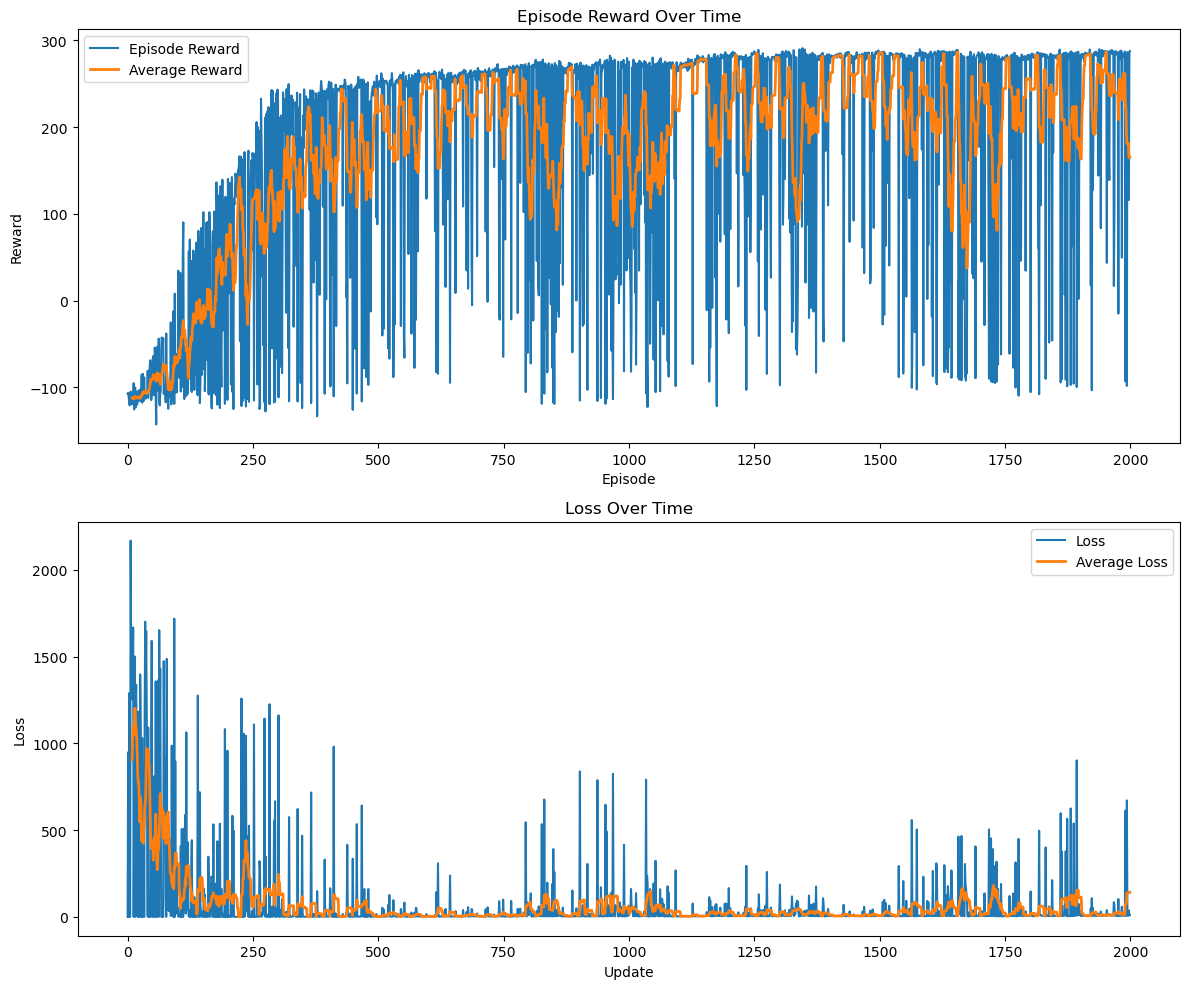

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import time
import matplotlib.pyplot as plt

ENV_NAME = 'BipedalWalker-v3'
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-4
GAMMA = 0.99
LAMBDA = 0.97
CLIP_EPSILON = 0.2
ENTROPY_COEF = 0.02
VALUE_LOSS_COEF = 0.8
MAX_GRAD_NORM = 1.0
PPO_EPOCHS = 15
MINI_BATCH_SIZE = 128
TOTAL_EPISODES = 2000
ROLLOUT_LENGTH = 2048  # or 4096 if memory allows
EVAL_INTERVAL = 100
EVAL_EPISODES = 3

# Early stopping parameters
patience = 15
min_delta = 1e-2

# Device configuration (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize the environment with render_mode for evaluation
env = gym.make(ENV_NAME)
eval_env = gym.make(ENV_NAME, render_mode='human')  # Set render_mode to 'human' for rendering

env.action_space.seed(seed)
eval_env.action_space.seed(seed + 1)

obs_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
action_high = torch.tensor(env.action_space.high).to(device)
action_low = torch.tensor(env.action_space.low).to(device)

# Define the Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, obs_size, action_size):
        super(ActorCritic, self).__init__()
        # Common network
        self.shared = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
        )
        # Actor network
        self.actor_mean = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, action_size),
            nn.Tanh()  # Assuming action space is bounded between -1 and 1
        )
        # Actor log_std (learned)
        self.actor_log_std = nn.Parameter(torch.zeros(action_size))
        # Critic network
        self.critic = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )

    def forward(self, x):
        shared_out = self.shared(x)
        # Actor
        mean = self.actor_mean(shared_out)
        std = self.actor_log_std.exp().expand_as(mean)
        dist = Normal(mean, std)
        # Critic
        value = self.critic(shared_out)
        return dist, value

# Initialize the network and optimizer
model = ActorCritic(obs_size, action_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Storage for rollouts
class RolloutBuffer:
    def __init__(self):
        self.obs = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.values = []

    def clear(self):
        self.obs = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.values = []

buffer = RolloutBuffer()

# Function to compute Generalized Advantage Estimation (GAE)
def compute_gae(next_value, rewards, dones, values):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + GAMMA * values[step + 1] * (1 - dones[step]) - values[step]
        gae = delta + GAMMA * LAMBDA * (1 - dones[step]) * gae
        returns.insert(0, gae + values[step])
    return returns

# Function to evaluate the agent
def evaluate_policy(model, eval_env, episodes=5):
    model.eval()
    total_rewards = []
    for episode in range(episodes):
        state, info = eval_env.reset(seed=seed + episode)
        state = torch.FloatTensor(state).to(device)
        terminated = truncated = False
        episode_reward = 0
        while not (terminated or truncated):
            with torch.no_grad():
                dist, _ = model(state)
                action = dist.mean
            action_clipped = torch.clamp(action, action_low, action_high)
            next_state, reward, terminated, truncated, _ = eval_env.step(action_clipped.cpu().numpy())
            # Render the environment
            eval_env.render()
            state = torch.FloatTensor(next_state).to(device)
            episode_reward += reward
            time.sleep(0.01)  # Slow down the rendering
        total_rewards.append(episode_reward)
    model.train()
    avg_reward = np.mean(total_rewards)
    print(f"Evaluation over {episodes} episodes: Average Reward = {avg_reward}")
    return avg_reward

# Initialize variables for early stopping and tracking
best_avg_reward = -np.inf
no_improvement_counter = 0
all_episode_rewards = []
all_episode_lengths = []
all_losses = []
all_actor_losses = []
all_critic_losses = []
all_entropies = []
all_avg_rewards = []
episode_rewards = []
episode_lengths = []
total_timesteps = 0
next_eval = EVAL_INTERVAL
episode_count = 0

while episode_count < TOTAL_EPISODES:
    state, info = env.reset(seed=seed + episode_count)
    state = torch.FloatTensor(state).to(device)
    episode_reward = 0
    episode_length = 0
    done = False

    while not done:
        dist, value = model(state)
        action = dist.sample()
        action_clipped = torch.clamp(action, action_low, action_high)
        log_prob = dist.log_prob(action).sum(dim=-1)
        next_state, reward, terminated, truncated, _ = env.step(action_clipped.cpu().numpy())
        next_state = torch.FloatTensor(next_state).to(device)
        done = terminated or truncated
        # Store in buffer (detach tensors to prevent retaining computational graph)
        buffer.obs.append(state)
        buffer.actions.append(action.detach())  # Detach action
        buffer.log_probs.append(log_prob.detach())  # Detach log_prob
        buffer.rewards.append(reward)
        buffer.dones.append(done)
        buffer.values.append(value.detach().squeeze())
        state = next_state
        episode_reward += reward
        episode_length += 1
        total_timesteps += 1

        # Check if it's time to update the policy
        if len(buffer.rewards) >= ROLLOUT_LENGTH or done:
            # Compute next value
            with torch.no_grad():
                _, next_value = model(state)
            next_value = next_value.detach().squeeze()
            # Compute returns and advantages
            returns = compute_gae(next_value, buffer.rewards, buffer.dones, buffer.values)
            advantages = [ret - val for ret, val in zip(returns, buffer.values)]
            advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
            returns = torch.tensor(returns, dtype=torch.float32).to(device)

            # Flatten the buffers
            obs_tensor = torch.stack(buffer.obs)
            actions_tensor = torch.stack(buffer.actions)
            log_probs_tensor = torch.stack(buffer.log_probs)
            values_tensor = torch.stack(buffer.values).to(device)
            # Clear buffer
            buffer.clear()

            # Normalize advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # PPO Optimization step
            total_loss = 0
            total_actor_loss = 0
            total_critic_loss = 0
            total_entropy = 0
            num_updates = 0
            for _ in range(PPO_EPOCHS):
                # Create mini-batches
                indices = np.arange(len(obs_tensor))
                np.random.shuffle(indices)
                for start in range(0, len(obs_tensor), MINI_BATCH_SIZE):
                    end = start + MINI_BATCH_SIZE
                    mini_batch_indices = indices[start:end]
                    mb_obs = obs_tensor[mini_batch_indices]
                    mb_actions = actions_tensor[mini_batch_indices]
                    mb_log_probs = log_probs_tensor[mini_batch_indices]
                    mb_returns = returns[mini_batch_indices]
                    mb_advantages = advantages[mini_batch_indices]
                    # Forward pass
                    dist, value = model(mb_obs)
                    entropy = dist.entropy().mean()
                    new_log_probs = dist.log_prob(mb_actions).sum(dim=-1)
                    # Ratio for clipping
                    ratio = (new_log_probs - mb_log_probs).exp()
                    surr1 = ratio * mb_advantages
                    surr2 = torch.clamp(ratio, 1.0 - CLIP_EPSILON, 1.0 + CLIP_EPSILON) * mb_advantages
                    actor_loss = -torch.min(surr1, surr2).mean()
                    critic_loss = VALUE_LOSS_COEF * (mb_returns - value.squeeze()).pow(2).mean()
                    loss = actor_loss + critic_loss - ENTROPY_COEF * entropy
                    # Backpropagation
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                    optimizer.step()
                    # Accumulate losses
                    total_loss += loss.item()
                    total_actor_loss += actor_loss.item()
                    total_critic_loss += critic_loss.item()
                    total_entropy += entropy.item()
                    num_updates += 1

            # Compute average losses
            avg_loss = total_loss / num_updates
            avg_actor_loss = total_actor_loss / num_updates
            avg_critic_loss = total_critic_loss / num_updates
            avg_entropy = total_entropy / num_updates

            # Store losses
            all_losses.append(avg_loss)
            all_actor_losses.append(avg_actor_loss)
            all_critic_losses.append(avg_critic_loss)
            all_entropies.append(avg_entropy)

            # Verbose logging
            print(f"Episode {episode_count} | Timesteps {total_timesteps} | Avg Loss: {avg_loss:.4f} | "
                  f"Actor Loss: {avg_actor_loss:.4f} | Critic Loss: {avg_critic_loss:.4f} | "
                  f"Entropy: {avg_entropy:.4f}")

    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
    episode_count += 1

    # Print average reward every 10 episodes
    if episode_count % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        avg_length = np.mean(episode_lengths[-10:])
        print(f"Episode {episode_count} | Average Reward (last 10 episodes): {avg_reward:.2f} | "
              f"Average Length: {avg_length:.2f}")

    # Evaluate the agent periodically
    if episode_count % EVAL_INTERVAL == 0:
        print(f"\nEvaluating at episode {episode_count}...")
        avg_reward = evaluate_policy(model, eval_env, episodes=EVAL_EPISODES)
        all_avg_rewards.append(avg_reward)

        # Early stopping and model saving
        if avg_reward > best_avg_reward + min_delta:
            best_avg_reward = avg_reward
            no_improvement_counter = 0
            # Save the model
            torch.save(model.state_dict(), f'best_model_episode_{episode_count}.pth')
            print(f"Best model saved with average reward {best_avg_reward} at episode {episode_count}")
        else:
            no_improvement_counter += 1
            print(f"No improvement for {no_improvement_counter} evaluation(s)")

        if no_improvement_counter >= patience:
            print(f"Early stopping at episode {episode_count} due to no improvement in average reward")
            break
        print()

env.close()
eval_env.close()

# Function to compute moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plotting the results
window_size = 10  # You can adjust the window size for averaging
episodes = np.arange(len(episode_rewards))
updates = np.arange(len(all_losses))

# Compute moving averages
avg_episode_rewards = moving_average(episode_rewards, window_size)
avg_losses = moving_average(all_losses, window_size)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot episode rewards and average rewards
ax1.plot(episodes, episode_rewards, label='Episode Reward')
ax1.plot(episodes[window_size-1:], avg_episode_rewards, label='Average Reward', linewidth=2)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.set_title('Episode Reward Over Time')
ax1.legend()

# Plot losses and average losses
ax2.plot(updates, all_losses, label='Loss')
ax2.plot(updates[window_size-1:], avg_losses, label='Average Loss', linewidth=2)
ax2.set_xlabel('Update')
ax2.set_ylabel('Loss')
ax2.set_title('Loss Over Time')
ax2.legend()

plt.tight_layout()
plt.savefig('rewards_and_losses.png')
plt.show()

